In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
'AlexNet_v1_(1)_(1) (1).ipynb'	'checkpoint (7)'
'AlexNet_v1 (1).ipynb'		'checkpoint (8)'
 AlexNet_v2_512x512.ipynb	'checkpoint (9)'
 checkpoint			'cp-0000 (1).ckpt.data-00000-of-00001'
'checkpoint (1)'		'cp-0000 (2).ckpt.data-00000-of-00001'
'checkpoint (2)'		 cp-0000.ckpt.data-00000-of-00001
'checkpoint (3)'		 Fold_1
'checkpoint (4)'		'My Drive'
'checkpoint (5)'		 ResNet18_v1.ipynb
'checkpoint (6)'		 ResNet50_v1.ipynb


In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model, Sequential
from keras.callbacks import History, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, Callback, LambdaCallback
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.optimizers import Adam, SGD
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import sys

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
ROWS = 256
COLS = 256
CHANNELS = 3
CLASSES = 2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size_tr = 32
batch_size_val = 32
input_size = (256,256,3)

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        featurewise_center=False,	# set input mean to 0 over dataset
        samplewise_center=False,	# set each sample mean to 0
        featurewise_std_normalization=False,	# divide inputs by std of dataset
        samplewise_std_normalization=False,	#divide each input by its std
        zca_whitening=False,	# apply ZCA whitening
        rotation_range=90,	# randomly roate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,	# randomly shift image horizontally (fraction of width)
        height_shift_range=0.1,	# randomly shift image vertically (fraction of height)
        horizontal_flip=True,	# randomly flip images horizontally
        vertical_flip=True	# randomly flip images vertically
        )

test_datagen = ImageDataGenerator()
                                  

train_generator = train_datagen.flow_from_directory(
        '/mydrive/Fold_1/train',  
        batch_size=batch_size_tr,
        shuffle=True,
        target_size=(256,256),
        class_mode='categorical')  

validation_generator = test_datagen.flow_from_directory(
        '/mydrive/Fold_1/validation',  
        batch_size=batch_size_val,
        target_size=(256,256),
        shuffle=True,
        class_mode='categorical')

Found 82 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

In [ ]:
def ResNet50(input_shape=(256, 256, 3), classes=2):
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dropout(0.2)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

In [ ]:
model.summary()

In [ ]:
csv_logger = CSVLogger('/mydrive/Fold_1/ResNet50_SGD_1FC_512_LR_5_point2_dropout_v1.csv',append=True)

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
sgd = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [ ]:
import sys
global best_val_acc
global best_val_loss
best_val_loss = sys.float_info.max
best_val_acc = 0

#Saving the best model
checkpointer = ModelCheckpoint(filepath="/mydrive/Fold_1/ResNet50_best_weights_SGD_1FC_512_LR_5_point2_dropout_v1.hdf5", 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_best_only=True)

#Stop training when a monitored metric has stopped improving
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [ ]:
def saveModel(epoch,logs):
  global best_val_loss
  global best_val_acc
  val_accuracy = logs['val_accuracy']
  val_loss = logs['val_loss']

  if val_accuracy > best_val_acc:
    best_val_acc = val_accuracy
    best_val_loss = val_loss
    model.save("/mydrive/Fold_1/ResNet50_best_weights_SGD_1FC_512_LR_5_point2_dropout_v1.hdf5")
  elif val_accuracy == best_val_acc:
    if val_loss < best_val_loss:
      best_val_loss=val_loss
      model.save("/mydrive/Fold_1/ResNet50_best_weights_SGD_1FC_512_LR_5_point2_dropout_v1.hdf5")

Lambdacallbacks = [LambdaCallback(on_epoch_end=saveModel)]

In [ ]:
history = model.fit_generator(train_generator,
                        epochs=6000,
                        validation_data=validation_generator,
                        verbose=1,
                        initial_epoch = 5210,
                        callbacks=[csv_logger,Lambdacallbacks,early_stopping])

Epoch 5211/6000
3/3 [==============================] - 1s 457ms/step - loss: 0.1938 - accuracy: 0.8659 - val_loss: 0.2524 - val_accuracy: 0.8929
Epoch 5212/6000
3/3 [==============================] - 2s 503ms/step - loss: 0.0988 - accuracy: 0.9634 - val_loss: 0.2149 - val_accuracy: 0.8929
Epoch 5213/6000
3/3 [==============================] - 2s 507ms/step - loss: 0.1591 - accuracy: 0.9146 - val_loss: 0.1892 - val_accuracy: 0.9643
Epoch 5214/6000
3/3 [==============================] - 1s 380ms/step - loss: 0.1119 - accuracy: 0.9390 - val_loss: 0.2054 - val_accuracy: 0.9643
Epoch 5215/6000
3/3 [==============================] - 1s 387ms/step - loss: 0.0920 - accuracy: 0.9878 - val_loss: 0.2537 - val_accuracy: 0.9643
Epoch 5216/6000
3/3 [==============================] - 1s 379ms/step - loss: 0.1111 - accuracy: 0.9512 - val_loss: 0.2888 - val_accuracy: 0.9643
Epoch 5217/6000
3/3 [==============================] - 1s 383ms/step - loss: 0.1042 - accuracy: 0.9512 - val_loss: 0.3108 - val_ac

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator, epochs = 1500, callbacks=[csv_logger])

In [ ]:
datagen = ImageDataGenerator()
test_generator = datagen.flow_from_directory(
        '/mydrive/Fold_1/test',  
        batch_size=32,
        target_size=(256,256),
        shuffle=True,
        class_mode='categorical')

Found 28 images belonging to 2 classes.


In [ ]:
model.evaluate(test_generator)

In [ ]:
pred=model.predict_generator(test_generator)
predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
import pandas as pd
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results

In [ ]:
#saving the weights
model.save_weights("/mydrive/Fold_1/ResNet50_SGD_1FC_512_LR_5_point2_dropout_5493_epochs_85_v1.h5")

In [ ]:
model.load_weights("/mydrive/Fold_1/ResNet50_SGD_1FC_512_LR_5_point2_dropout_5493_epochs_85_v1.h5")

In [ ]:
import matplotlib.pyplot as plt

def append_history(history, h):
     '''
	This function appends the statistics over epochs
     '''
     try:
       history.history['loss'] = history.history['loss'] + h.history['loss']
       history.history['val_loss'] = history.history['val_loss'] + h.history['val_loss']
       history.history['accuracy'] = history.history['accuracy'] + h.history['accuracy']
       history.history['val_accuracy'] = history.history['val_accuracy'] + h.history['val_accuracy']
     except:
       history = h
                
     return history
            

def unfreeze_layer_onwards(model, layer_name):
    '''
        This layer unfreezes all layers beyond layer_name
    '''
    trainable = False
    for layer in model.layers:
        try:
            if layer.name == layer_name:
                trainable = True
            layer.trainable = trainable
        except:
            continue
    
    return model
            

def plot_performance(history):
    '''
	This function plots the train & test accuracy, loss plots
    '''
        
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    #plt.axis([0, 2000, 0.2, 0.8])
    plt.title('Accuracy v/s Epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left') 

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    #plt.axis([0, 2000, 0,1])
    plt.title('Loss v/s Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left') 

    plt.tight_layout()
    plt.show()

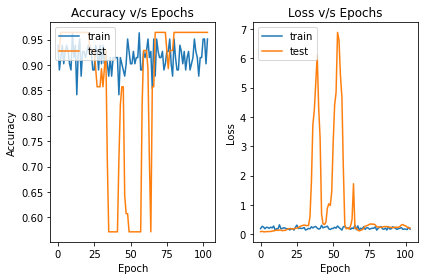

In [ ]:
plot_performance(history)

In [ ]:
np.save('/mydrive/Fold_1/my_history_ResNet_512x512_96_.npy',history.history)

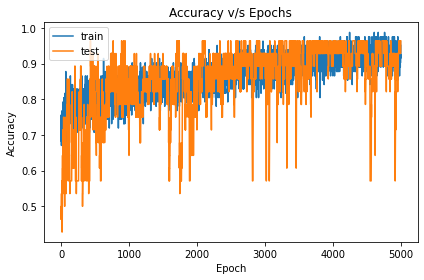

In [ ]:

plt.plot(history.history['accuracy'])

plt.plot(history.history['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()

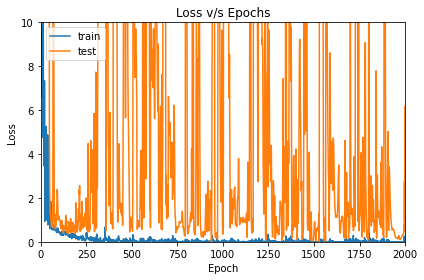

In [ ]:


plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
plt.axis([0, 2000, 0,10])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
plot_model(model, to_file='/mydrive/Fold_1/model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
n=200
history.history['accuracy'] = np.convolve(history.history['accuracy'], np.ones((n,)) / n, mode = "valid")
history.history['val_accuracy'] = np.convolve(history.history['val_accuracy'], np.ones((n,)) / n, mode = "valid")

history.history['val_loss'] = np.convolve(history.history['val_loss'], np.ones((n,)) / n, mode = "valid")
history.history['loss'] = np.convolve(history.history['loss'], np.ones((n,)) / n, mode = "valid")

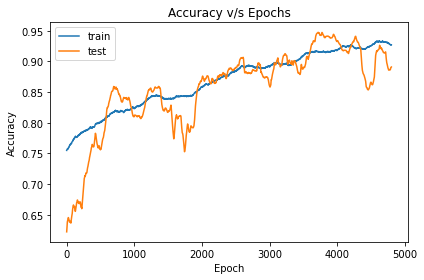

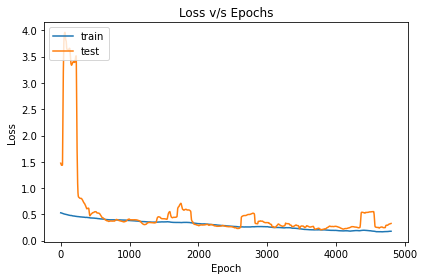

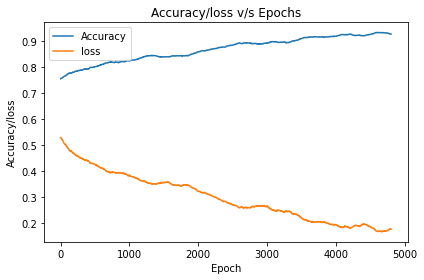

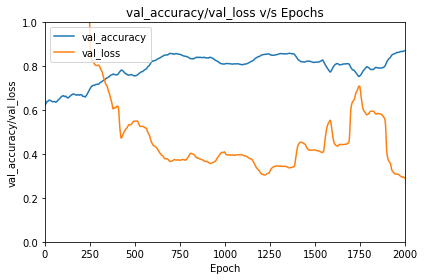

In [ ]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()



plt.plot(history.history['loss'])

plt.plot(history.history['val_loss'])
#plt.axis([0, 200, 0,1])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()



plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy/loss v/s Epochs')
plt.ylabel('Accuracy/loss')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'loss'], loc='upper left') 

plt.tight_layout()
plt.show()

plt.plot(history.history['val_accuracy'])

plt.plot(history.history['val_loss'])
plt.axis([0, 2000, 0,1])
plt.title('val_accuracy/val_loss v/s Epochs')
plt.ylabel('val_accuracy/val_loss')
plt.xlabel('Epoch')
plt.legend(['val_accuracy', 'val_loss'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv('/mydrive/Fold_1/ResNet18_512_fc_v1.csv')

history2 = df.to_dict(orient='list')

In [ ]:
n=200


history2['val_accuracy'] = np.convolve(history2['val_accuracy'], np.ones((n,)) / n, mode = "valid")
history2['accuracy'] = np.convolve(history2['accuracy'], np.ones((n,)) / n, mode = "valid")

history2['val_loss'] = np.convolve(history2['val_loss'], np.ones((n,)) / n, mode = "valid")
history2['loss'] = np.convolve(history2['loss'], np.ones((n,)) / n, mode = "valid")

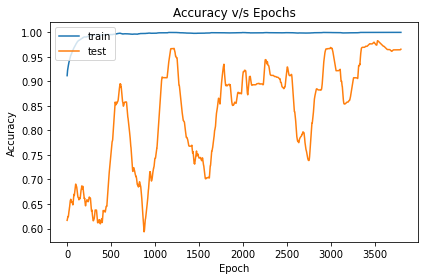

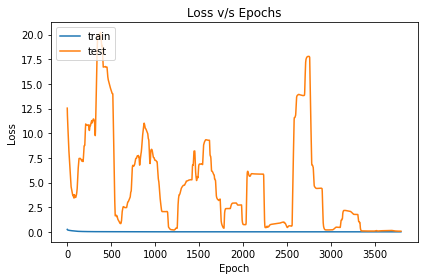

In [ ]:
plt.plot(history2['accuracy'])
plt.plot(history2['val_accuracy'])
#plt.axis([0, 200, 0.2, 0.8])
plt.title('Accuracy v/s Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left') 

plt.tight_layout()
plt.show()

plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
#plt.axis([0, 200, 0,1])
plt.title('Loss v/s Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
## Now Predict
from os import listdir
from os.path import isfile, join
predict_dir_path='/mydrive/Fold_1/pred/pred/'
onlyfiles = [f for f in listdir(predict_dir_path) if isfile(join(predict_dir_path, f))]
print(onlyfiles)

['bent_21.png', 'straight_31.png', 'straight_32.png', 'bent_46.png', 'bent_10.png', 'bent_28.png', 'straight_33.png', 'bent_70.png', 'bent_51.png', 'straight_3.png', 'straight_57.png', 'bent_38.png', 'bent_56.png', 'straight_13.png', 'straight_6.png', 'bent_7.png', 'straight_36.png', 'bent_1.png', 'bent_18.png', 'straight_21.png', 'bent_22.png', 'straight_27.png', 'straight_11.png', 'bent_71.png', 'straight_46.png', 'bent_73.png', 'bent_19.png', 'bent_66.png']


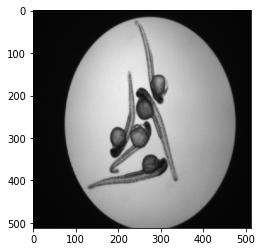

AttributeError: ignored

In [ ]:
# predicting images
from keras.preprocessing import image
neg_counter = 0 
pos_counter  = 0
fig=plt.figure()
for file in onlyfiles:
    img = image.load_img(predict_dir_path+file, target_size=(512, 512))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #plt.subplot(4, 7, len(onlyfiles))
    plt.imshow(img)
    plt.show()
    
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size=32)
    #classes = classes[0][0]
    
    if classes == 0:
        print(file + ": " + 'negative')
        neg_counter += 1
    else:
        print(file + ": " + 'positive')
        pos_counter += 1

print("Total negative/bent fishes :",neg_counter)
print("Total positive/normal fishes :",pos_counter)